In [239]:
from data import digs_data_loader
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser_vpsde
from analysis import plotting
from analysis import utils as au
from collections import defaultdict
import numpy as np
from model import loss
from model import ipa_pytorch
from model import reverse_se3_diffusion
import tree
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial.transform import Rotation

Rigid = ru.Rigid

from omegaconf import OmegaConf
import importlib
import os
import torch
import tree
import copy

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [240]:
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(ipa_pytorch)
importlib.reload(plotting)
importlib.reload(loss)
importlib.reload(au)
importlib.reload(train_se3_diffusion)
importlib.reload(r3_diffuser_vpsde)
importlib.reload(reverse_se3_diffusion)


<module 'model.reverse_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/model/reverse_se3_diffusion.py'>

In [241]:
base_conf_path = '../config/base.yaml'
base_conf = OmegaConf.load(base_conf_path)

if True:
    # Load model checkpoint
    # ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_20D_08M_2022Y_06h_23m_25s/'
    # ckpt_dir = '../pkl_jar/ckpt/sanity_check_1_rescale_20D_08M_2022Y_08h_40m_20s'
    ckpt_dir = '../pkl_jar/ckpt/sanity_check_no_crop_20D_08M_2022Y_11h_04m_15s'
#     ckpt_dir = '../pkl_jar/ckpt/mini_subset_len_50_20D_08M_2022Y_12h_11m_52s'

    # ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_12h_40m_22s'
    # ckpt_dir = '../pkl_jar/ckpt/mini_subset_20D_08M_2022Y_13h_04m_15s'

    # ckpt_dir = '../pkl_jar/ckpt/subset_100_20D_08M_2022Y_18h_43m_20s'


    if len(os.listdir(ckpt_dir)) != 1:
        raise ValueError(f'Ambiguous ckpt in {ckpt_dir}')
    ckpt_path = os.path.join(
        ckpt_dir, os.listdir(ckpt_dir)[0])
    print(ckpt_path)
    ckpt_pkl = du.read_pkl(ckpt_path)
    ckpt_conf = ckpt_pkl['conf']
    ckpt_model = ckpt_pkl['model']

    conf = OmegaConf.merge(base_conf, ckpt_conf)
else:
    conf = base_conf

conf.experiment.data_location = 'digs'
conf.data.digs.cache_dir = '../pkl_jar/'
conf.model.num_blocks = 1

# print(OmegaConf.to_yaml(ckpt_conf))

../pkl_jar/ckpt/sanity_check_no_crop_20D_08M_2022Y_11h_04m_15s/epoch_901.pkl


In [242]:
# Initialize model class
exp = train_se3_diffusion.Experiment(conf=conf)
exp.model.load_state_dict(ckpt_model)
exp.model.to(device)
exp_diffuser = exp.diffuser
train_loader, _, valid_loader, _ = exp.create_digs_dataset(0, 1)
exp_diffuser = exp.diffuser

INFO: Number of model parameters 1251854
INFO: Using R^3 VP-SDE
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl
INFO: Loaded data at ../pkl_jar/dataset_5.0_260_60_80.0_100_2020-Apr-30_1.pkl


Using cached IGSO3.


## Training

In [243]:
num_epochs = 3
step = 0
epoch = 0
train_losses = defaultdict(list)
log_losses = defaultdict(list)
latest_aux_data = []
sampled_ts = []
def update_logs(x,y):
    for k in y:
        if 'loss' in k:
            x[k].append(y[k])
log_freq = 100

exp._model = exp._model.to(device)
exp._model.train()
while epoch < num_epochs:
    epoch += 1
    for train_features in train_loader:
        step += 1
        exp.step = step
        exp.num_epochs = epoch
        sampled_ts.append(train_features['t'])
        train_features = tree.map_structure(
            lambda x: x.to(device), train_features)
        _, aux_data = exp.update_fn(train_features)
        aux_data = tree.map_structure(du.move_to_np, aux_data)
        latest_aux_data.append(aux_data)
        update_logs(train_losses, aux_data)
        update_logs(log_losses, aux_data)
        if step == 1 or step % log_freq == 0:
            print_log = f'Step {step}: '
            for k,v in log_losses.items():
                print_log += f'{k}={np.mean(v):.4f} '
            print(print_log)
            log_losses = defaultdict(list)
            latest_aux_data = []
#         if step > 10:
#             break
#     break

Step 1: total_loss=6.1321 rot_loss=3.1712 trans_loss=2.9609 


Text(0, 0.5, 'Total loss')

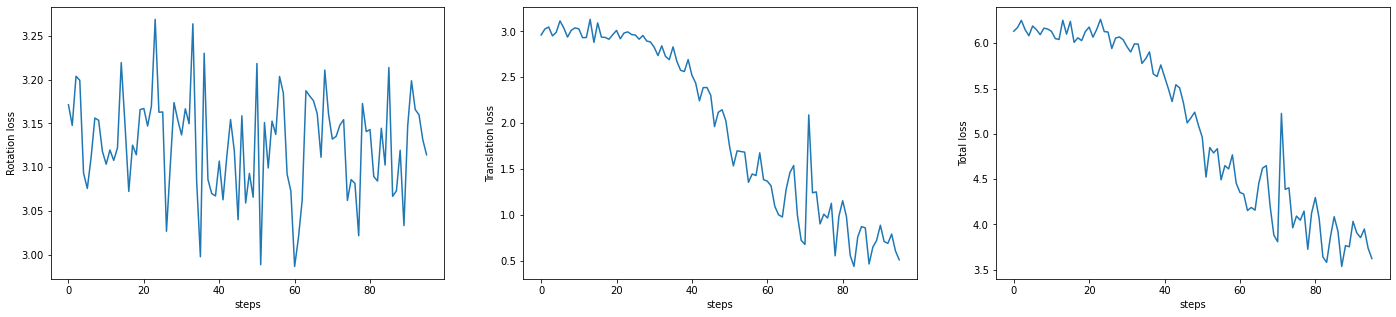

In [244]:
f, axes = plt.subplots(1, 3, figsize=[24, 5])

axes[0].plot(train_losses['rot_loss'])
axes[0].set_xlabel('steps')
axes[0].set_ylabel('Rotation loss')

axes[1].plot(train_losses['trans_loss'])
axes[1].set_xlabel('steps')
axes[1].set_ylabel('Translation loss')

axes[2].plot(train_losses['total_loss'])
axes[2].set_xlabel('steps')
axes[2].set_ylabel('Total loss')

## Inference

In [58]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [84]:
# Preprocess init data
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]

# Initialized features
init_rots, init_pos = exp_diffuser.random_init(num_res, return_rigid=False)
rigids_init = ru.Rigid(
    rots=ru.Rotation(rot_mats=init_rots),
    trans=init_pos).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)

# Perturbed features
rand_rot = torch.Tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix())

# perturbed_pos = init_pos + 10.0
# perturbed_rots = init_rots

perturbed_pos = torch.einsum(
    'ni,ji->nj', init_pos, rand_rot)
perturbed_rots = torch.einsum(
    'nij,jk->nik', init_rots, rand_rot)
# perturbed_rots = torch.einsum(
#     'nij,kj->nik', init_rots, rand_rot)

rigids_perturbed = ru.Rigid(
    rots=ru.Rotation(rot_mats=perturbed_rots),
    trans=perturbed_pos).to_tensor_7()
rigids_perturbed *= res_mask[:, None]

perturbed_feats = {
    'rigids_t': rigids_perturbed[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
perturbed_feats = tree.map_structure(lambda x: x[None].to(device), perturbed_feats)

In [85]:
exp.diffuser._diffuse_rots = False

# Run inference
sample_steps, rot_scores, trans_scores, local_trans_score = exp.inference_fn(init_feats, add_noise=False)
perturbed_steps, perturbed_rot_scores, perturbed_trans_scores, perturbed_local_trans_score = exp.inference_fn(perturbed_feats, add_noise=False)


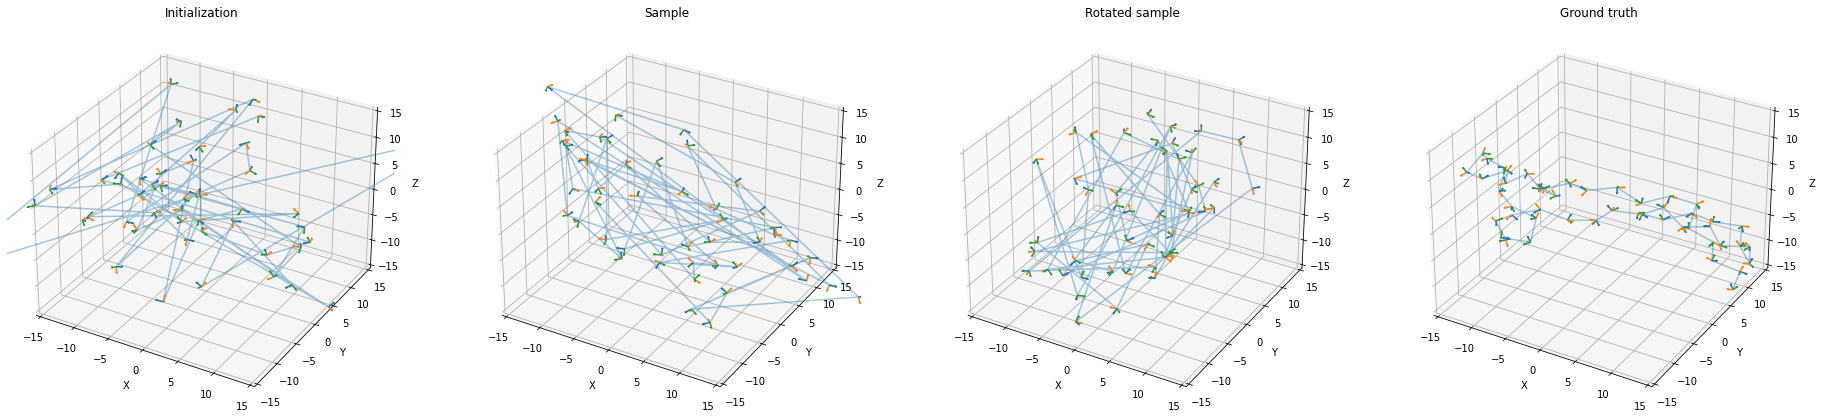

In [86]:
# Plot out SE(3)
final_rigid = sample_steps[-1][0]
perturbed_final_rigid = perturbed_steps[-1][0]
f, axes = plt.subplots(1, 4, figsize=[32, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.0
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(perturbed_final_rigid, res_mask, axes[2], title='Rotated sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(rigids_0, res_mask, axes[3], title='Ground truth', scale_factor=scale_factor, ax_lim=ax_lim)


In [87]:
init_out = exp.model(init_feats)
pertub_out = exp.model(perturbed_feats)

In [88]:
print(init_out['local_trans_score'][0][2])
print(pertub_out['local_trans_score'][0][2])

tensor([ 0.0910,  0.6039, -0.0009], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward>)
tensor([-0.7995,  0.5677,  0.9769], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward>)


In [70]:
print(local_trans_score[0][0][:3])
print(perturbed_local_trans_score[0][0][:3])

tensor([[ 0.3331, -0.4140,  1.4135],
        [-0.8357, -1.2869,  2.4304],
        [ 0.2342, -0.8441,  0.4708]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.4550, -0.9635,  1.5611],
        [ 0.9838,  0.2319,  0.7571],
        [-0.6597, -0.8789, -0.0047]], device='cuda:0', dtype=torch.float64)


In [62]:
# Check that initialization is equivariant
first_rigid = ru.Rigid.from_tensor_7(sample_steps[0][0])
perturbed_first_rigid = ru.Rigid.from_tensor_7(perturbed_steps[0][0])

first_trans = du.move_to_np(first_rigid.get_trans())
perturbed_first_trans = du.move_to_np(perturbed_first_rigid.get_trans())
rot_first_trans = np.einsum('ni,ji->nj', first_trans, rand_rot)
np.testing.assert_almost_equal(
    perturbed_first_trans,
    rot_first_trans,
    decimal=3)

first_rots = du.move_to_np(first_rigid.get_rots().get_rot_mats())
perturbed_first_rots = du.move_to_np(perturbed_first_rigid.get_rots().get_rot_mats())
rot_first_rots = np.einsum('nij,jk->nik', first_rots, rand_rot)
np.testing.assert_almost_equal(
    perturbed_first_trans,
    rot_first_trans,
    decimal=3)


In [ ]:
# See how rotation deviation occurs through out diffusion
for step_idx in range(len(sample_steps)):
    rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
        sample_steps[step_idx][0],
        perturbed_steps[step_idx][0],
        res_mask.to(final_rigid.device),
        length_scale=scale_factor,
        return_align=True)
    rot_amt = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True).tolist()
    print(step_idx, [round(x, 2) for x in rot_amt])

In [ ]:
# See how translation deviation occurs through out diffusion
def trans_ca_rmsd(pred_ca, gt_ca, res_mask, length_scale=1.0, return_align=False):
    ca_mask = du.move_to_np(res_mask).astype(bool)
    pred_ca = du.move_to_np(pred_ca)[ca_mask]
    gt_ca = du.move_to_np(gt_ca)[ca_mask]

    aligned_ca, rot, trans, reflection = du.rigid_transform_3D(
        pred_ca, gt_ca)
    rmsd = loss.np_rmsd(aligned_ca, gt_ca) * length_scale 
    if return_align:
        return rmsd, aligned_ca, gt_ca, rot, trans, reflection
    else:
        return rmsd 

for step_idx in range(len(trans_scores)):
    rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = trans_ca_rmsd(
        trans_scores[step_idx][0],
        perturbed_trans_scores[step_idx][0],
        res_mask.to(final_rigid.device),
        length_scale=scale_factor,
        return_align=True)
    rot_amt = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True).tolist()
    print(step_idx, [round(x, 2) for x in rot_amt])

## Equivariant test with real data

In [245]:
# Sample data point to initializez.
data_iter = iter(train_loader)
raw_data_feats = next(data_iter)

In [251]:
# Preprocess init data
batch_idx = 0
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']
xyz_0 = data_feats['xyz']

# res_mask = torch.zeros_like(res_mask)
# res_mask[0] = 1

rigids_0 = rigids_0[torch.where(res_mask.bool())]
xyz_0 = xyz_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]

In [252]:
# Initialized features
init_feats = {
    'rigids_t': rigids_0,
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)

In [323]:
rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).float()
# xyz_rot = torch.einsum('...i,ji->...j', xyz_0, rot)
xyz_rot = xyz_0
# xyz_rot[:, 1] += 10.0
# xyz_rot = xyz_0

# rigids_rot = du.rigid_frames_from_atom_14(xyz_rot).to_tensor_7()
# rigids_rot[:, 4:] += 10.0

rigids_rot = du.rigid_frames_from_atom_14(xyz_rot)
# rigids_rot = rigids_rot.apply_trans_fn(lambda x: x + 10.0).to_tensor_7()

perturbed_feats = copy.deepcopy(init_feats)
perturbed_feats['rigids_t'] = rigids_rot[None]
perturbed_feats = tree.map_structure(lambda x: x.to(device), perturbed_feats)

In [324]:
apply_0 = ru.Rigid.from_tensor_7(rigids_0.to(device)).apply(torch.ones((1, 110, 3)).to(device))
apply_perturb = ru.Rigid.from_tensor_7(rigids_rot.to(device)).apply(torch.ones((1, 110, 3)).to(device))

In [325]:
trans_0 = ru.Rigid.from_tensor_7(rigids_0.to(device)).get_trans()
trans_perturb = ru.Rigid.from_tensor_7(rigids_rot.to(device)).get_trans()

In [326]:
trans_0[3:5]

tensor([[ 3.4879e-01, -2.3208e-01,  1.2153e+00],
        [ 5.3189e-02,  1.1185e-03,  1.2688e+00]], device='cuda:0')

In [327]:
trans_perturb[3:5]

tensor([[43.4879, 37.6792, 52.1526],
        [40.5319, 40.0112, 52.6876]], device='cuda:0')

In [308]:
init_out = exp.model(init_feats)
pertub_out = exp.model(perturbed_feats)

In [309]:
print(init_out['pt_att'][0, 3, :2, :2])
print(pertub_out['pt_att'][0, 3, :2, :2])

tensor([[-4.1585, -3.1335],
        [-2.5640, -3.9893]], device='cuda:0', grad_fn=<SliceBackward>)
tensor([[ -4.1585, -10.0541],
        [ -4.2044,  -3.9893]], device='cuda:0', grad_fn=<SliceBackward>)


In [310]:
apply_0 = ru.Rigid.from_tensor_7(rigids_0.to(device)).apply(torch.ones((1, 110, 3)).to(device))
apply_perturb = ru.Rigid.from_tensor_7(rigids_rot.to(device)).apply(torch.ones((1, 110, 3)).to(device))

In [311]:
# ru.Rigid.from_tensor_7(rigids_0.to(device)).get_rots().get_rot_mats()[0]
# ru.Rigid.from_tensor_7(rigids_rot.to(device)).get_rots().get_rot_mats()[0]

In [312]:
ru.Rigid.from_tensor_7(rigids_0.to(device)).get_trans()[0]

tensor([ 1.2944, -0.0412,  1.4939], device='cuda:0')

In [313]:
ru.Rigid.from_tensor_7(rigids_rot.to(device)).get_trans()[0]

tensor([32.9439, 19.5882, 34.9386], device='cuda:0')

In [276]:
ru.Rigid.from_tensor_7(rigids_rot.to(device)).get_trans()[0]

tensor([12.9439, -0.4118, 14.9386], device='cuda:0')

In [266]:
apply_0[0, :2]

tensor([[-0.3834,  0.0663,  1.9103],
        [-0.5129,  0.3265,  1.9766]], device='cuda:0')

In [267]:
apply_perturb[0, :2]

tensor([[-0.3834,  0.0663,  1.9103],
        [-0.5129,  0.3265,  1.9766]], device='cuda:0')

In [201]:
mats_0 = ru.Rigid.from_tensor_7(rigids_0).get_rots().get_rot_mats()
mats_rot = ru.Rigid.from_tensor_7(rigids_rot).get_rots().get_rot_mats()

In [202]:
rot_to_euler = lambda x: Rotation.from_matrix(x).as_euler('xyz', degrees=True)
rot = torch.tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix()).float()
print(rot_to_euler(mats_rot[0]))
# print(rot_to_euler(mats_0[0]))
# print(rot_to_euler(torch.einsum('ij,kj->ik', mats_0[0], rot)))
# print(rot_to_euler(mats_0[0] @ rot))
print(rot_to_euler(rot.T @ mats_0[0]))
# print(rot_to_euler(mats_0[0] @ rot))

[-44.72217079 -24.21800503 119.07144214]
[-44.7221713  -24.21800489  29.07144094]


In [203]:
init_out = exp.model(init_feats)
pertub_out = exp.model(perturbed_feats)

In [204]:
init_out['q_pts'].shape

torch.Size([1, 110, 4, 4, 3])

In [205]:
init_out['q_pts'][0, 3, 0, 0]

tensor([-0.2420,  0.3887, -0.4418], device='cuda:0', grad_fn=<SelectBackward>)

In [206]:
pertub_out['q_pts'][0, 3, 0, 0]

tensor([12.8971,  8.3000, 20.4955], device='cuda:0', grad_fn=<SelectBackward>)

In [196]:
print(init_out['q_pts'][0, 3, :2, :2])
print(pertub_out['q_pts'][0, 3, :2, :2])

tensor([[[-0.2420,  0.3887, -0.4418],
         [ 1.3203, -1.4209, -0.1209]],

        [[-1.5603,  1.0883,  0.6091],
         [ 1.2293,  2.2089,  4.2713]]], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([[[ 2.8971, -1.7000, 10.4955],
         [ 4.4594, -3.5096, 10.8164]],

        [[ 1.5788, -1.0004, 11.5465],
         [ 4.3684,  0.1202, 15.2087]]], device='cuda:0',
       grad_fn=<SliceBackward>)


In [ ]:
r[..., None].apply(q_pts)

In [151]:
print(init_out['init_edge_embed'][0, 2, :10])
print(pertub_out['init_edge_embed'][0, 2, :10])

tensor([[-0.9033, -0.1068,  0.8205,  ..., -0.1755, -0.2938, -1.5912],
        [-0.4361, -0.1251, -0.6405,  ...,  0.5775, -0.4054, -1.9584],
        [ 0.3572, -0.3787, -0.3012,  ...,  1.9278,  0.1360, -1.9265],
        ...,
        [-0.1071, -0.1520,  0.1968,  ...,  0.8586,  0.3069, -1.0890],
        [-0.0619, -0.0480,  0.0772,  ...,  1.8489, -0.0156, -0.9479],
        [ 0.1422, -0.5174,  0.6107,  ...,  0.2899, -0.3453, -0.5091]],
       device='cuda:0', grad_fn=<SliceBackward>)
tensor([[-0.9033, -0.1068,  0.8205,  ..., -0.1755, -0.2938, -1.5912],
        [-0.4361, -0.1251, -0.6405,  ...,  0.5775, -0.4054, -1.9584],
        [ 0.3572, -0.3787, -0.3012,  ...,  1.9278,  0.1360, -1.9265],
        ...,
        [-0.1071, -0.1520,  0.1968,  ...,  0.8586,  0.3069, -1.0890],
        [-0.0619, -0.0480,  0.0772,  ...,  1.8489, -0.0156, -0.9479],
        [ 0.1422, -0.5174,  0.6107,  ...,  0.2899, -0.3453, -0.5091]],
       device='cuda:0', grad_fn=<SliceBackward>)


In [145]:
print(init_out['ipa_embed'][0, 2, :10])
print(pertub_out['ipa_embed'][0, 2, :10])

tensor([-0.7613,  1.1247, -0.6380, -0.2891, -0.3140, -0.8000,  1.2919, -1.2090,
         0.8009, -0.1208], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 0.8447,  0.2078,  0.8841,  1.1393,  1.1362,  0.7121,  0.5191, -1.5055,
        -0.8160,  1.3014], device='cuda:0', grad_fn=<SliceBackward>)


In [146]:
print(init_out['node_embed'][0, 2, :10])
print(pertub_out['node_embed'][0, 2, :10])

tensor([-0.1401,  2.0898, -0.6291, -1.9760, -0.3358, -0.6429,  0.1622,  0.1076,
        -0.5356, -1.4873], device='cuda:0', grad_fn=<SliceBackward>)
tensor([ 1.4659,  1.1728,  0.8930, -0.5476,  1.1144,  0.8692, -0.6106, -0.1889,
        -2.1524, -0.0651], device='cuda:0', grad_fn=<SliceBackward>)


In [147]:
print(init_out['local_trans_score'][0][2])
print(pertub_out['local_trans_score'][0][2])

tensor([ 0.1844, -1.5604, -0.6147], device='cuda:0', grad_fn=<SelectBackward>)
tensor([ 1.0527, -0.2370,  0.2413], device='cuda:0', grad_fn=<SelectBackward>)


In [148]:
print(init_out['rot_score'][0][2])
print(pertub_out['rot_score'][0][2])

tensor([ 0.0464, -0.0095, -0.0212], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.0089,  0.0281, -0.0068], device='cuda:0', grad_fn=<SelectBackward>)


In [149]:
rot_out = torch.einsum('ij,j->i', rot.to(device), init_out['trans_score'][0][0])
print(rot_out)
print(pertub_out['trans_score'][0][0])

tensor([0.1845, 1.5320, 1.1126], device='cuda:0', grad_fn=<ViewBackward>)
tensor([-0.1965,  0.3232,  1.5241], device='cuda:0', grad_fn=<SelectBackward>)


In [ ]:
# Preprocess init data
batch_idx = 1
data_feats = tree.map_structure(lambda x: x[batch_idx], raw_data_feats)
res_mask = data_feats['res_mask']
res_idx = data_feats['res_idx']
rigids_0 = data_feats['rigids_0']

rigids_0 = rigids_0[torch.where(res_mask.bool())]
res_mask = res_mask[torch.where(res_mask.bool())]

num_res = res_mask.shape[0]

# Initialized features
init_rots, init_pos = exp_diffuser.random_init(num_res, return_rigid=False)
rigids_init = ru.Rigid(
    rots=ru.Rotation(rot_mats=init_rots),
    trans=init_pos).to_tensor_7()
rigids_init *= res_mask[:, None]
init_feats = {
    'rigids_t': rigids_init[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
init_feats = tree.map_structure(lambda x: x[None].to(device), init_feats)

# Perturbed features
rand_rot = torch.Tensor(Rotation.from_euler('z', 90, degrees=True).as_matrix())

# perturbed_pos = init_pos + 10.0
# perturbed_rots = init_rots

perturbed_pos = torch.einsum(
    'ni,ji->nj', init_pos, rand_rot)
perturbed_rots = torch.einsum(
    'nij,jk->nik', init_rots, rand_rot)
# perturbed_rots = torch.einsum(
#     'nij,kj->nik', init_rots, rand_rot)

rigids_perturbed = ru.Rigid(
    rots=ru.Rotation(rot_mats=perturbed_rots),
    trans=perturbed_pos).to_tensor_7()
rigids_perturbed *= res_mask[:, None]

perturbed_feats = {
    'rigids_t': rigids_perturbed[torch.where(res_mask.bool())],
    'res_mask': res_mask,
    'res_idx': res_idx[torch.where(res_mask.bool())],
    't': torch.tensor(exp_diffuser.num_t),
}
perturbed_feats = tree.map_structure(lambda x: x[None].to(device), perturbed_feats)

In [172]:
# Check that translation scores are equivariant
pred_score = du.move_to_np(trans_scores[0][0])
perturbed_pred_score = du.move_to_np(perturbed_trans_scores[0][0])
rot_pred_score = np.einsum(
    'ni,ji->nj', pred_score, rand_rot)
print(perturbed_pred_score[:2])
print(rot_pred_score[:2])

[[-2.4090967  -0.6936738  -0.84815156]
 [-0.84813064  1.763173    2.122296  ]]
[[-2.3719208  -0.55899566 -0.79125595]
 [-0.97364193  1.8144053   2.1122255 ]]


In [215]:
# Check that Rotation scores are equivariant
pred_score = Rotation.from_rotvec(du.move_to_np(rot_scores[0][0])).as_matrix()
perturbed_pred_score = Rotation.from_rotvec(du.move_to_np(perturbed_rot_scores[0][0])).as_matrix()
print(pred_score[2])
print(perturbed_pred_score[2])

[[ 0.91165607 -0.08126895  0.40283815]
 [-0.06562779  0.93887976  0.33793163]
 [-0.40567993 -0.3345148   0.85060193]]
[[ 0.69284691  0.19066502  0.69542074]
 [-0.46221405  0.85765485  0.22535824]
 [-0.55346304 -0.47757199  0.68235157]]


In [191]:
# Check that final output is equivariant
# step_idx = 2
for step_idx in range(len(sample_steps)):
    final_rigid = sample_steps[step_idx][0]
    perturbed_final_rigid = perturbed_steps[step_idx][0]

    final_trans = du.move_to_np(ru.Rigid.from_tensor_7(final_rigid).get_trans())
    perturbed_final_trans = du.move_to_np(ru.Rigid.from_tensor_7(perturbed_final_rigid).get_trans())
    rot_final_trans = np.einsum(
        'ni,ji->nj', final_trans, rand_rot)
    try:
        np.testing.assert_almost_equal(
            perturbed_final_trans,
            rot_final_trans,
            decimal=1)
    except Exception:
        print(step_idx)
        break

    # print(perturbed_final_trans[:2])
    # print(rot_final_trans[:2])


56


In [193]:
# Check that final output is equivariant
step_idx = -1

final_rigid = sample_steps[step_idx][0]
perturbed_final_rigid = perturbed_steps[step_idx][0]

final_trans = du.move_to_np(ru.Rigid.from_tensor_7(final_rigid).get_trans())
perturbed_final_trans = du.move_to_np(ru.Rigid.from_tensor_7(perturbed_final_rigid).get_trans())
rot_final_trans = np.einsum(
    'ni,ji->nj', final_trans, rand_rot)

print(perturbed_final_trans[:2])
print(rot_final_trans[:2])


[[ 0.09818257  0.07054804  0.13172232]
 [ 0.16635084  0.10348433 -0.05648043]]
[[-0.29897457 -0.15731196 -0.00757228]
 [-0.15847328 -0.15235357  0.09225237]]


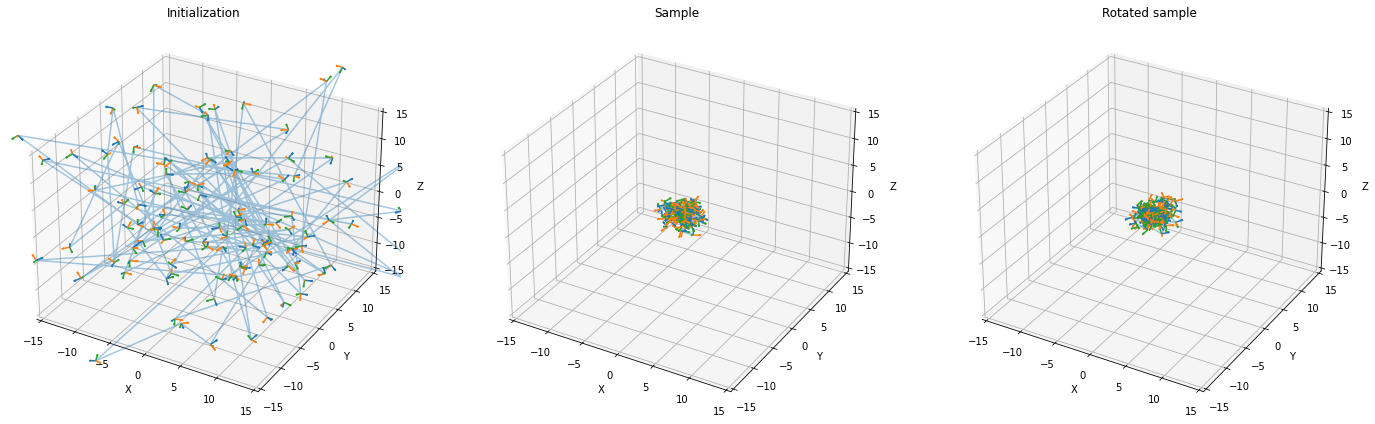

In [239]:
# Plot out SE(3)
final_rigid = sample_steps[-1][0]
perturbed_final_rigid = perturbed_steps[-1][0]
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.
plotting.viz_frames(init_feats['rigids_t'][0], res_mask, axes[0], title='Initialization', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(final_rigid, res_mask, axes[1], title='Sample', scale_factor=scale_factor, ax_lim=ax_lim)
plotting.viz_frames(perturbed_final_rigid, res_mask, axes[2], title='Rotated sample', scale_factor=scale_factor, ax_lim=ax_lim)

In [195]:
# Calculate FAPE and Ca-RMSD metrics.
fape_loss = loss.rigids_fape(
    final_rigid,
    perturbed_final_rigid.to(final_rigid.device),
    res_mask.to(final_rigid.device),
    length_scale=scale_factor)
rmsd_loss, aligned_pred_ca, gt_ca, align_rot_mat, align_trans, reflection = loss.rigids_ca_rmsd(
    final_rigid,
    perturbed_final_rigid.to(final_rigid.device),
    res_mask.to(final_rigid.device),
    length_scale=scale_factor,
    return_align=True)
align_rot_euler = Rotation.from_matrix(align_rot_mat).as_euler('xyz', degrees=True)
print(f'FAPE: {fape_loss:2.4f}\nCa-RMSD: {rmsd_loss:2.4f}')
print(f'Alignment rotation: {align_rot_euler}\nAlignment translation: {align_trans[:,0]}\nAlignment reflection: {reflection}')


FAPE: 0.0312
Ca-RMSD: 2.4666
Alignment rotation: [ 31.91871851 -29.29814981 -15.00260579]
Alignment translation: [ 2.8517702e-09 -2.6136266e-09 -1.4276120e-09]
Alignment reflection: False


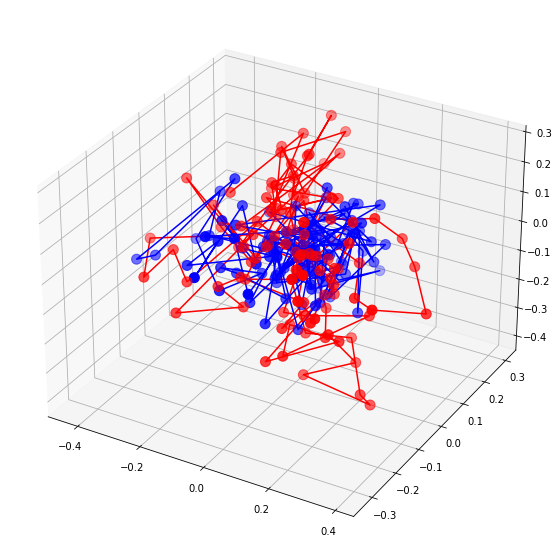

In [196]:
# Visualize aligned Ca structures
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

plotting.plt_3d(aligned_pred_ca, ax, color='r', s=100, mode='scatter')
plotting.plt_3d(aligned_pred_ca, ax, color='r', mode='line')
plotting.plt_3d(gt_ca, ax, color='b', s=100, mode='scatter')
plotting.plt_3d(gt_ca, ax, color='b', mode='line')

In [88]:
sample_traj = torch.stack(sample_steps)[:, 0]

INFO: Animation.save using <class 'matplotlib.animation.PillowWriter'>


Saved gif to: dev_diffusion_1.gif


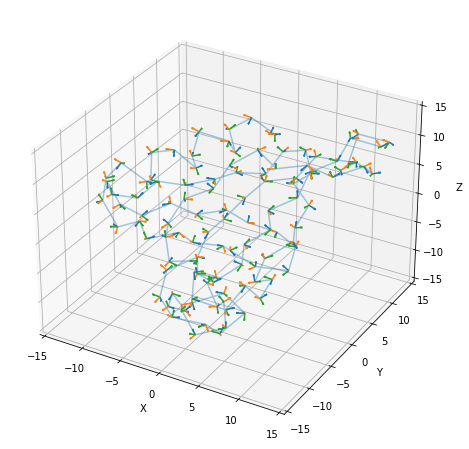

In [89]:
ax_lim = 15

fig, ax = plt.subplots(1, 1, figsize=[8, 8], subplot_kw=dict(projection="3d"))
bb_mask = du.move_to_np(res_mask).astype(bool)

def extract_se3_vec(step, scale_factor=10.0):
    frame = sample_traj[step]
    frame = frame[bb_mask]
    se3_vec = au.rigids_to_se3_vec(du.move_to_np(frame), scale_factor=scale_factor)
    return se3_vec


_ = plotting.plot_se3(extract_se3_vec(0), ax=ax, ax_lim=ax_lim)

def update(frame):
    ax.clear()
    plotting.plot_se3(extract_se3_vec(frame), ax=ax, ax_lim=ax_lim)

anim = FuncAnimation(
    fig,
    update,
    frames=list(range(1, exp.diffuser.num_t)),
    interval=10,
    blit=False)
writergif = animation.PillowWriter(fps=30) 
# f = f'/data/rsg/chemistry/jyim/protein_diffusion_samples/se3_diffusion/dev_diffusion_{b_idx}.gif'
f = f'dev_diffusion_1.gif'
anim.save(f, writer=writergif)
print(f'Saved gif to: {f}')